<a href="https://colab.research.google.com/github/dlguswn3659/big_pie/blob/master/dogs_vs_cats2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Set the random seed number for reproducible results
seedNum = 1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Set the TensorFlow version to 2.x in Colab
%tensorflow_version 2.x

In [0]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot
from matplotlib.image import imread
from datetime import datetime
from email.message import EmailMessage

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun  1 11:44:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = pyplot.subplots(2, 1, figsize=(12,12))
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='red', label='test')
	pyplot.show()

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the mountStorage flag to mount G Drive for storing files (setting True will mount the drive!)
mountStorage = False

Num GPUs Available:  1


In [0]:
# Colab-Specific Setup - Mount Google Drive for storing downloaded files
if (mountStorage):
    from google.colab import drive
    drive.mount('/content/gdrive')

In [0]:
# Set the default optimizer for the remaining portion of the script
default_opt = Adam(learning_rate=0.001)

# **Section 1. Data Preparation**

In [0]:
!wget https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
!unzip train.zip > unzip_output.txt

--2020-06-01 11:44:30--  https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.223.100, 13.227.223.27, 13.227.223.91, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.223.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 543.16M   118MB/s    in 4.7s    

2020-06-01 11:44:35 (116 MB/s) - ‘train.zip’ saved [569546721/569546721]



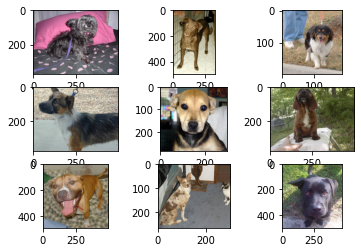

In [0]:
# plot dog photos from the dogs vs cats dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

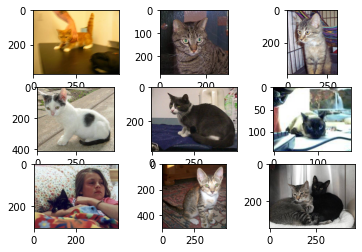

In [0]:
# plot cat photos from the dogs vs cats dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [0]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(seedNum)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

# **Section 2. Fit and Evaluate Models**

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 75s 255ms/step - loss: 2.7154 - accuracy: 0.6379 - val_loss: 0.5755 - val_accuracy: 0.7135
Epoch 2/20
293/293 [==============================] - 73s 249ms/step - loss: 0.4522 - accuracy: 0.7908 - val_loss: 0.5697 - val_accuracy: 0.7228
Epoch 3/20
293/293 [==============================] - 73s 248ms/step - loss: 0.3179 - accuracy: 0.8691 - val_loss: 0.6298 - val_accuracy: 0.7082
Epoch 4/20
293/293 [==============================] - 73s 250ms/step - loss: 0.2241 - accuracy: 0.9148 - val_loss: 0.6520 - val_accuracy: 0.7251
Epoch 5/20
293/293 [==============================] - 73s 250ms/step - loss: 0.1453 - accuracy: 0.9545 - val_loss: 0.7198 - val_accuracy: 0.7255
Epoch 6/20
293/293 [==============================] - 73s 250ms/step - loss: 0.1028 - accuracy: 0.9722 - val_loss: 0.9030 - val_accuracy: 0.7120
Epoch 7/20
293/293 [=========================

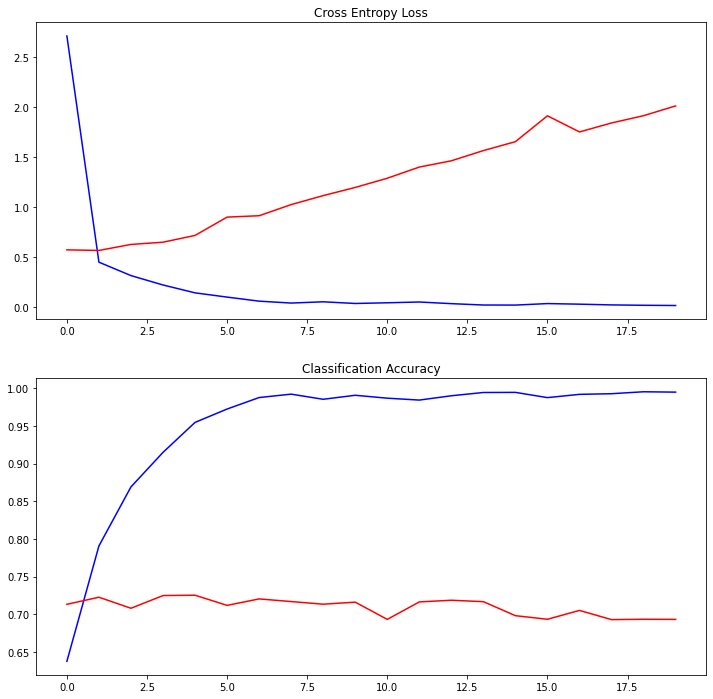

Total time for the model processing: 0:25:02.723049


In [0]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model1 = define_model1()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model1.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model1.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 75s 255ms/step - loss: 1.5522 - accuracy: 0.5771 - val_loss: 0.6133 - val_accuracy: 0.6564
Epoch 2/20
293/293 [==============================] - 75s 254ms/step - loss: 0.5462 - accuracy: 0.7227 - val_loss: 0.5657 - val_accuracy: 0.7111
Epoch 3/20
293/293 [==============================] - 75s 255ms/step - loss: 0.4294 - accuracy: 0.8011 - val_loss: 0.5875 - val_accuracy: 0.7133
Epoch 4/20
293/293 [==============================] - 75s 256ms/step - loss: 0.2839 - accuracy: 0.8787 - val_loss: 0.7014 - val_accuracy: 0.7024
Epoch 5/20
293/293 [==============================] - 75s 255ms/step - loss: 0.1452 - accuracy: 0.9481 - val_loss: 0.9384 - val_accuracy: 0.7176
Epoch 6/20
293/293 [==============================] - 75s 256ms/step - loss: 0.0568 - accuracy: 0.9837 - val_loss: 1.1808 - val_accuracy: 0.7055
Epoch 7/20
293/293 [=========================

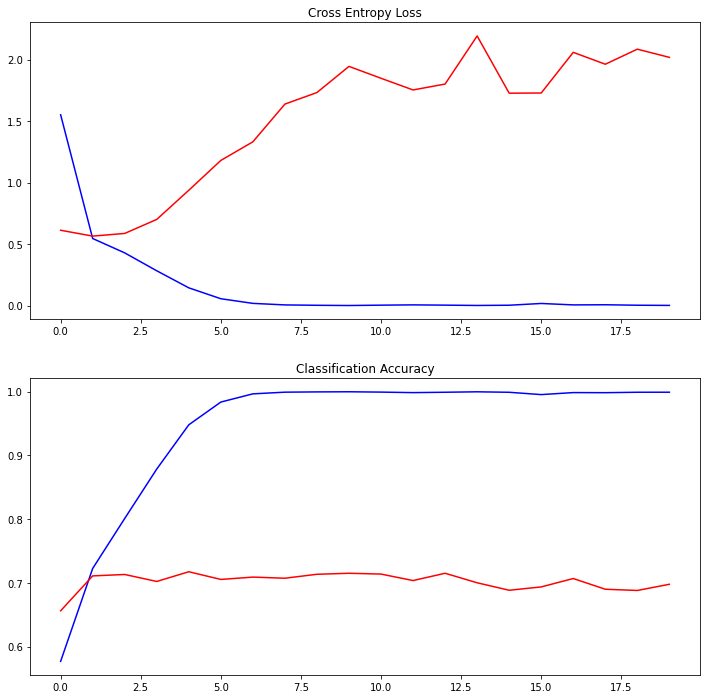

Total time for the model processing: 0:25:23.738805


In [0]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model2 = define_model2()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model2.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model2.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 76s 259ms/step - loss: 1.1858 - accuracy: 0.6189 - val_loss: 0.5819 - val_accuracy: 0.6951
Epoch 2/20
293/293 [==============================] - 76s 258ms/step - loss: 0.5512 - accuracy: 0.7231 - val_loss: 0.5427 - val_accuracy: 0.7271
Epoch 3/20
293/293 [==============================] - 76s 259ms/step - loss: 0.4943 - accuracy: 0.7607 - val_loss: 0.5044 - val_accuracy: 0.7530
Epoch 4/20
293/293 [==============================] - 76s 259ms/step - loss: 0.4341 - accuracy: 0.7947 - val_loss: 0.4815 - val_accuracy: 0.7799
Epoch 5/20
293/293 [==============================] - 76s 260ms/step - loss: 0.3746 - accuracy: 0.8318 - val_loss: 0.4597 - val_accuracy: 0.7895
Epoch 6/20
293/293 [==============================] - 76s 260ms/step - loss: 0.3204 - accuracy: 0.8597 - val_loss: 0.4660 - val_accuracy: 0.7865
Epoch 7/20
293/293 [=========================

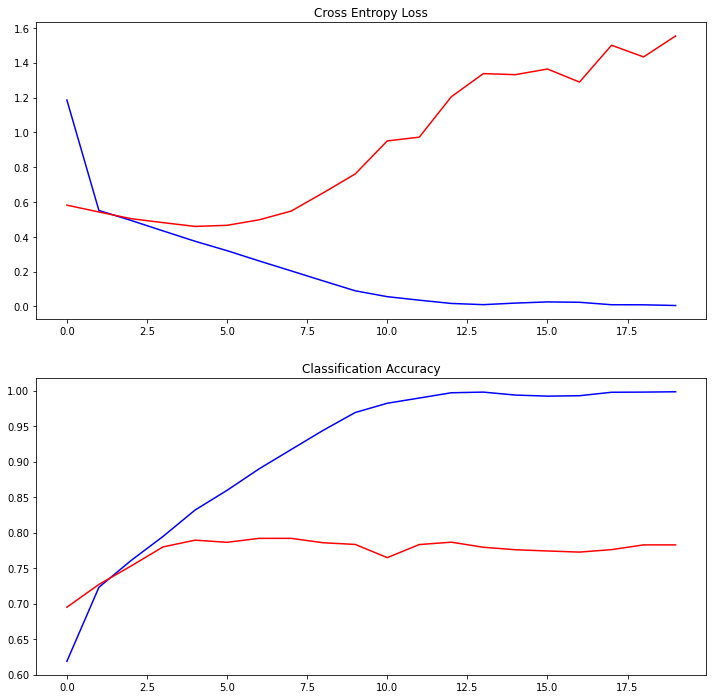

Total time for the model processing: 0:25:46.800397


In [0]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model3 = define_model3()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model3.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model3.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 77s 264ms/step - loss: 1.3074 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 2/50
293/293 [==============================] - 79s 269ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/50
293/293 [==============================] - 79s 268ms/step - loss: 0.6933 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/50
293/293 [==============================] - 79s 270ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/50
293/293 [==============================] - 79s 268ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 6/50
293/293 [==============================] - 82s 279ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 7/50
293/293 [=========================

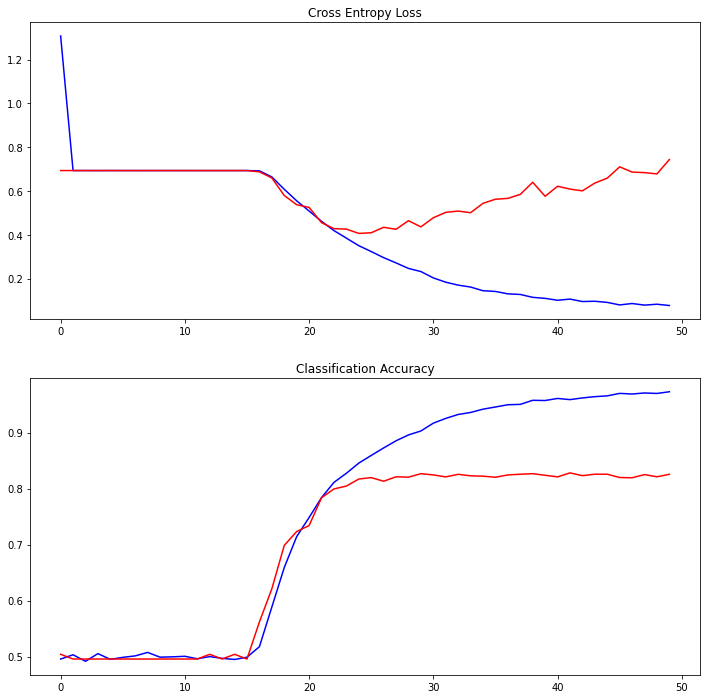

Total time for the model processing: 1:07:14.396168


In [0]:
# baseline model with VGG-3 and dropout (variation #1)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model4 = define_model4()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model4.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model4.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 81s 277ms/step - loss: 1.8075 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 2/50
293/293 [==============================] - 78s 265ms/step - loss: 0.6933 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/50
293/293 [==============================] - 78s 265ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/50
293/293 [==============================] - 77s 264ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/50
293/293 [==============================] - 77s 264ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 6/50
293/293 [==============================] - 77s 264ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 7/50
293/293 [=========================

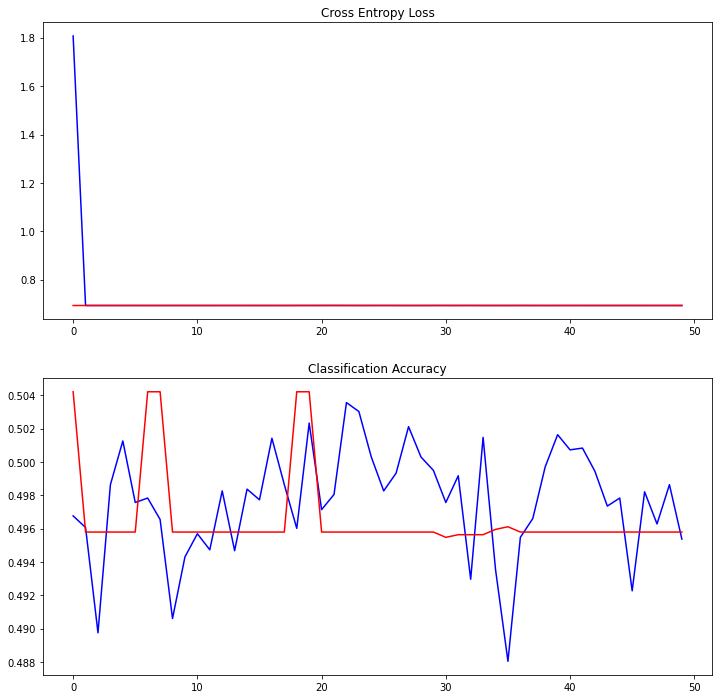

Total time for the model processing: 1:05:15.050469


In [17]:
# baseline model with VGG-3 and dropout (variation #2)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model5():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model5 = define_model5()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model5.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model5.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 201s 687ms/step - loss: 1.0113 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 2/50
293/293 [==============================] - 201s 686ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/50
293/293 [==============================] - 201s 685ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 4/50
293/293 [==============================] - 201s 685ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/50
293/293 [==============================] - 201s 685ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 6/50
293/293 [==============================] - 201s 686ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 7/50
293/293 [===================

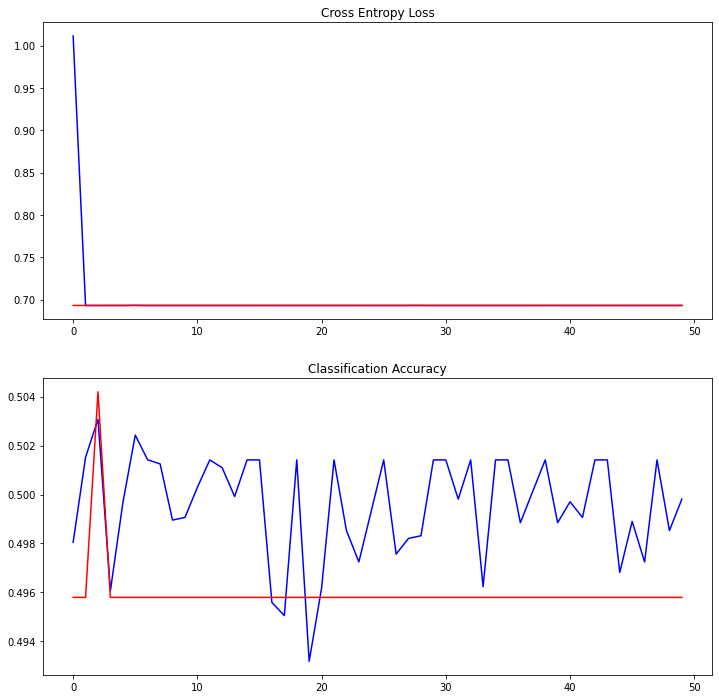

Total time for the model processing: 2:49:25.496396


In [18]:
# baseline model with VGG-3 and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model6():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model6 = define_model6()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model6.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model6.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 210s 718ms/step - loss: 1.0920 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 2/50
293/293 [==============================] - 202s 691ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/50
293/293 [==============================] - 203s 692ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/50
293/293 [==============================] - 203s 694ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 5/50
293/293 [==============================] - 204s 695ms/step - loss: 0.6932 - accuracy: 0.4918 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 6/50
293/293 [==============================] - 203s 694ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 7/50
293/293 [===================

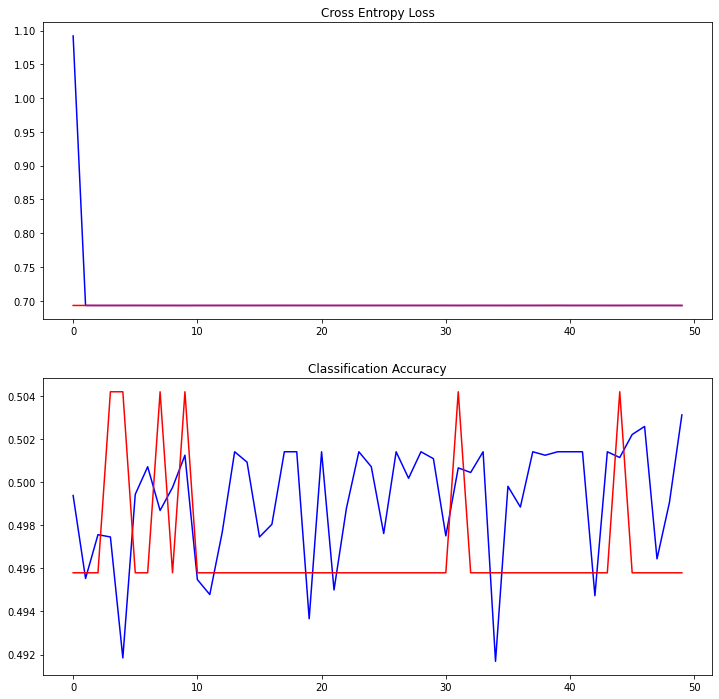

Total time for the model processing: 2:53:18.610632


In [19]:
# baseline model with VGG-3, dropout, and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model7():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model7 = define_model7()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model7.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model7.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))